<a href="https://colab.research.google.com/github/RodrigoGuedesDP/IA/blob/main/IA_Fundamentals/practica_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Costo de la solución con Hill Climbing: 718.3732773260135
Número de iteraciones de Hill Climbing: 21
Número de evaluaciones de vecinos en Hill Climbing: 507
Tiempo de ejecución de Hill Climbing: 0.0661 segundos
Rutas obtenidas con Hill Climbing:
Vehículo 1 (Capacidad 15): [10, 8, 12]
Vehículo 2 (Capacidad 15): [3, 5, 15, 14, 19]
Vehículo 3 (Capacidad 15): [6, 11, 13, 2]
Vehículo 4 (Capacidad 15): [7, 1, 0, 16]
Vehículo 5 (Capacidad 15): [9, 18, 17, 4]
Vehículo 6 (Capacidad 15): []
Vehículo 7 (Capacidad 15): []


<ipython-input-3-168cd4873527>:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(rutas))


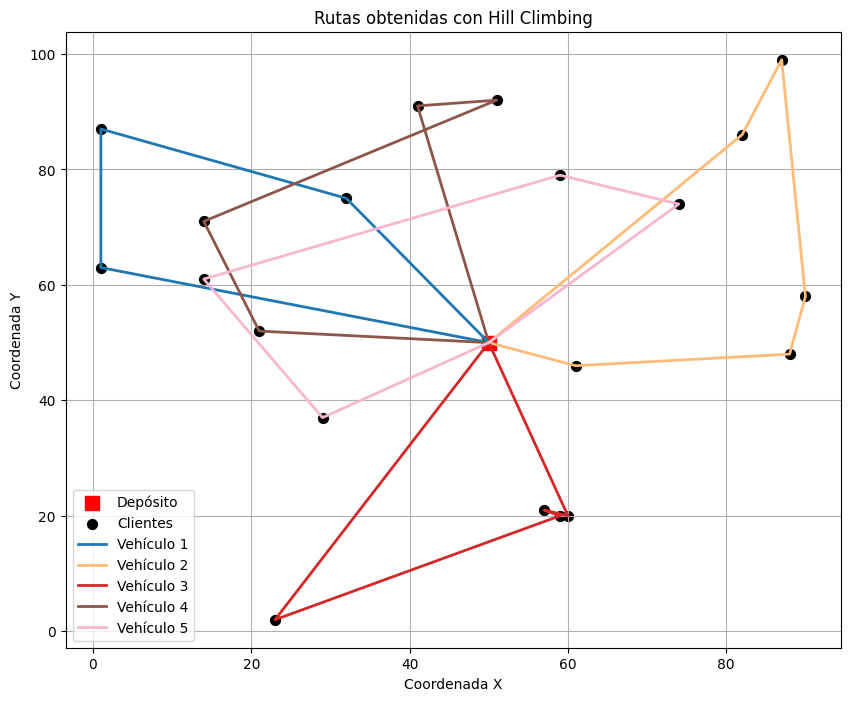


Costo de la solución con Simulated Annealing: 636.6106426416641
Número total de iteraciones de Simulated Annealing: 13500
Número de niveles de temperatura en Simulated Annealing: 135
Tiempo de ejecución de Simulated Annealing: 0.6307 segundos
Rutas obtenidas con Simulated Annealing:
Vehículo 1 (Capacidad 15): [17, 4]
Vehículo 2 (Capacidad 15): [7, 10, 18]
Vehículo 3 (Capacidad 15): [13, 11, 2, 6, 9]
Vehículo 4 (Capacidad 15): [1, 8, 12, 16, 0]
Vehículo 5 (Capacidad 15): []
Vehículo 6 (Capacidad 15): []
Vehículo 7 (Capacidad 15): [5, 3, 15, 14, 19]


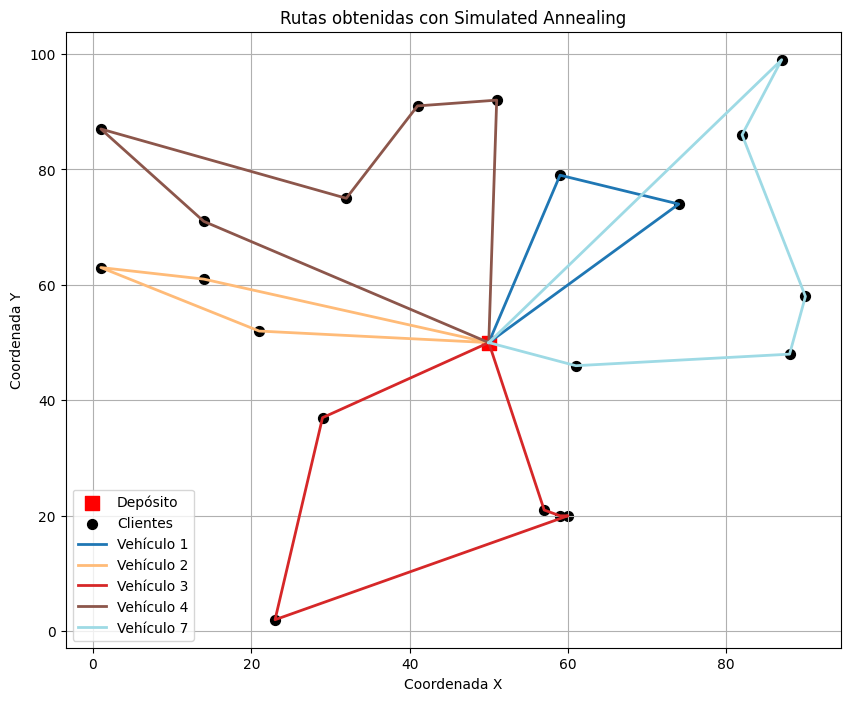

In [ ]:
import random
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import time


# Se realizaran corridas con el numero de clientes para analizar la funcion fitness y el tiempo de ejecucion de cada metodo heuristico implementado.
# Se realizaron corridas con N =10, N = 20, N =30, N =40. Con esto, se analizara la calidad de cada algoritmo cuando aumenta la complejidad.
numero_clientes = 20

# Para simplificar el problema, se mantendra constante La demanda maxima de cada cliente con un valor de 5.
demanda_maxima = 5

# Capacidad de los vehículos (todos iguales para simplificar)
capacidad_vehiculo = 15

# Coordenadas del depósito. Se tomo el caso donde el deposito se encuentra situado simetricamente al medio de los valores maximos de X y Y.
deposito = (50, 50)

# Generación de ubicaciones y demandas aleatorias para los clientes
np.random.seed(42)
ubicaciones_clientes = np.random.randint(0, 100, size=(numero_clientes, 2))
demandas_clientes = np.random.randint(1, demanda_maxima + 1, size=numero_clientes)

# Lista de clientes con sus demandas y ubicaciones
clientes = [
    {'index': i, 'demand': demandas_clientes[i], 'location': tuple(ubicaciones_clientes[i])}
    for i in range(numero_clientes)
]

# -------------------- Cálculo del número mínimo de vehículos --------------------

# Demanda total máxima posible
total_demanda_maxima = numero_clientes * demanda_maxima

# Número mínimo de vehículos necesarios
numero_vehiculos = math.ceil(total_demanda_maxima / capacidad_vehiculo)

# Crear la flota de vehículos con capacidades iguales
flota = [{'id_vehiculo': i, 'capacity': capacidad_vehiculo} for i in range(numero_vehiculos)]

# Verificación de que la capacidad total de la flota es suficiente
total_capacidad = sum(vehiculo['capacity'] for vehiculo in flota)
if total_capacidad < total_demanda_maxima:
    raise ValueError("La capacidad total de la flota es insuficiente para atender la demanda máxima posible.")

# -------------------- Funciones auxiliares --------------------

def crear_solucion_inicial(clientes, flota):
    """Crea una solución inicial respetando las restricciones de capacidad y número de vehículos."""
    rutas = [[] for _ in flota]
    capacidad_restante = [vehiculo['capacity'] for vehiculo in flota]
    no_visitados = set(c['index'] for c in clientes)
    lista_clientes = list(no_visitados)
    random.shuffle(lista_clientes)  # Mezclar clientes para asignación aleatoria

    for indice_cliente in lista_clientes:
        demanda = clientes[indice_cliente]['demand']
        asignado = False
        for idx, vehiculo in enumerate(flota):
            if demanda <= capacidad_restante[idx]:
                rutas[idx].append(indice_cliente)
                capacidad_restante[idx] -= demanda
                asignado = True
                break
        if not asignado:
            raise ValueError("No es posible asignar al cliente {} sin exceder la capacidad.".format(indice_cliente))
    return rutas

def distancia_total(rutas, clientes, deposito):
    """Calcula la distancia total de una solución."""
    total_dist = 0
    for ruta in rutas:
        if ruta:
            ubicacion_anterior = deposito
            for indice_cliente in ruta:
                ubicacion_cliente = clientes[indice_cliente]['location']
                # Calcular la distancia Euclidiana directamente
                dx = ubicacion_anterior[0] - ubicacion_cliente[0]
                dy = ubicacion_anterior[1] - ubicacion_cliente[1]
                distancia = math.hypot(dx, dy)
                total_dist += distancia
                ubicacion_anterior = ubicacion_cliente
            # Regreso al depósito
            dx = ubicacion_anterior[0] - deposito[0]
            dy = ubicacion_anterior[1] - deposito[1]
            distancia = math.hypot(dx, dy)
            total_dist += distancia
    return total_dist

def get_neighbors(solution, customers, fleet):
    """Genera soluciones vecinas moviendo clientes entre rutas."""
    neighbors = []
    num_vehicles = len(fleet)
    for i in range(num_vehicles):
        for j in range(num_vehicles):
            if i != j:
                for a in range(len(solution[i])):
                    # Intentar mover el cliente a de la ruta i a la ruta j
                    new_solution = copy.deepcopy(solution)
                    customer_a = new_solution[i][a]

                    # Verificar restricciones de capacidad
                    demand_a = customers[customer_a]['demand']
                    capacity_i = fleet[i]['capacity']
                    capacity_j = fleet[j]['capacity']

                    route_i_demand = sum(customers[c]['demand'] for c in new_solution[i]) - demand_a
                    route_j_demand = sum(customers[c]['demand'] for c in new_solution[j]) + demand_a

                    if route_i_demand <= capacity_i and route_j_demand <= capacity_j:
                        new_solution[i].pop(a)
                        new_solution[j].append(customer_a)
                        neighbors.append(new_solution)
    return neighbors

def get_random_neighbor(solution, customers, fleet):
    """Genera una solución vecina aleatoria para Simulated Annealing."""
    new_solution = copy.deepcopy(solution)
    num_vehicles = len(fleet)
    i, j = random.sample(range(num_vehicles), 2)
    if solution[i]:
        a = random.randrange(len(solution[i]))
        customer_a = solution[i][a]

        demand_a = customers[customer_a]['demand']
        capacity_i = fleet[i]['capacity']
        capacity_j = fleet[j]['capacity']

        route_i_demand = sum(customers[c]['demand'] for c in solution[i]) - demand_a
        route_j_demand = sum(customers[c]['demand'] for c in solution[j]) + demand_a

        if route_i_demand <= capacity_i and route_j_demand <= capacity_j:
            new_solution[i].pop(a)
            new_solution[j].append(customer_a)
            return new_solution
    return new_solution

# -------------------- Implementación de Hill Climbing --------------------

def hill_climbing(customers, depot, fleet):
    current_solution = crear_solucion_inicial(clientes, flota)
    current_cost = distancia_total(current_solution, clientes, deposito)
    improving = True
    iteration_count = 0  # Contador de iteraciones
    neighbor_evaluations = 0  # Contador de evaluaciones de vecinos
    while improving:
        improving = False
        neighbors = get_neighbors(current_solution, customers, fleet)
        iteration_count += 1
        for neighbor in neighbors:
            neighbor_evaluations += 1
            neighbor_cost = distancia_total(neighbor, clientes, deposito)
            if neighbor_cost < current_cost:
                current_solution = neighbor
                current_cost = neighbor_cost
                improving = True
                break  # Acepta el primer vecino mejor
    return current_solution, current_cost, iteration_count, neighbor_evaluations

# -------------------- Implementación de Simulated Annealing --------------------

def simulated_annealing(customers, depot, fleet, initial_temperature, cooling_rate, iteration_per_temp):
    current_solution = crear_solucion_inicial(clientes, flota)
    current_cost = distancia_total(current_solution, clientes, deposito)
    best_solution = current_solution
    best_cost = current_cost
    T = initial_temperature
    total_iterations = 0  # Contador de iteraciones totales
    temperature_steps = 0  # Contador de niveles de temperatura
    while T > 1:
        temperature_steps += 1
        for _ in range(iteration_per_temp):
            total_iterations += 1
            new_solution = get_random_neighbor(current_solution, customers, fleet)
            new_cost = distancia_total(new_solution, clientes, deposito)
            delta = new_cost - current_cost
            if delta < 0 or random.uniform(0, 1) < math.exp(-delta / T):
                current_solution = new_solution
                current_cost = new_cost
                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost
        T *= cooling_rate
    return best_solution, best_cost, total_iterations, temperature_steps

# -------------------- Función para visualizar las rutas --------------------

def plot_routes(rutas, clientes, deposito, titulo):
    """Visualiza las rutas en un gráfico, asignando un color distinto a cada ruta."""
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('tab20', len(rutas))

    # Dibujar el depósito
    plt.scatter(deposito[0], deposito[1], c='red', marker='s', s=100, label='Depósito')

    # Dibujar los clientes
    posiciones_clientes = np.array([cliente['location'] for cliente in clientes])
    plt.scatter(posiciones_clientes[:, 0], posiciones_clientes[:, 1], c='black', marker='o', s=50, label='Clientes')

    # Dibujar las rutas
    for idx, ruta in enumerate(rutas):
        if ruta:
            ruta_coords = [deposito] + [clientes[i]['location'] for i in ruta] + [deposito]
            xs, ys = zip(*ruta_coords)
            plt.plot(xs, ys, color=colors(idx % 20), linewidth=2, label=f'Vehículo {idx + 1}')

    plt.title(titulo)
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------- Ejecución y resultados --------------------

# Ejecutar Hill Climbing
start_time_hc = time.time()
hc_solution, hc_cost, hc_iterations, hc_neighbor_evaluations = hill_climbing(clientes, deposito, flota)
end_time_hc = time.time()
hc_execution_time = end_time_hc - start_time_hc

print("Costo de la solución con Hill Climbing:", hc_cost)
print("Número de iteraciones de Hill Climbing:", hc_iterations)
print("Número de evaluaciones de vecinos en Hill Climbing:", hc_neighbor_evaluations)
print("Tiempo de ejecución de Hill Climbing: {:.4f} segundos".format(hc_execution_time))
print("Rutas obtenidas con Hill Climbing:")
for idx, ruta in enumerate(hc_solution):
    capacidad = flota[idx]['capacity']
    print(f"Vehículo {idx + 1} (Capacidad {capacidad}): {ruta}")

# Visualizar las rutas obtenidas con Hill Climbing
plot_routes(hc_solution, clientes, deposito, "Rutas obtenidas con Hill Climbing")

# Ejecutar Simulated Annealing
start_time_sa = time.time()
sa_solution, sa_cost, sa_total_iterations, sa_temperature_steps = simulated_annealing(
    clientes,
    deposito,
    flota,
    initial_temperature=1000,
    cooling_rate=0.95,
    iteration_per_temp=100
)
end_time_sa = time.time()
sa_execution_time = end_time_sa - start_time_sa

print("\nCosto de la solución con Simulated Annealing:", sa_cost)
print("Número total de iteraciones de Simulated Annealing:", sa_total_iterations)
print("Número de niveles de temperatura en Simulated Annealing:", sa_temperature_steps)
print("Tiempo de ejecución de Simulated Annealing: {:.4f} segundos".format(sa_execution_time))
print("Rutas obtenidas con Simulated Annealing:")
for idx, ruta in enumerate(sa_solution):
    capacidad = flota[idx]['capacity']
    print(f"Vehículo {idx + 1} (Capacidad {capacidad}): {ruta}")

# Visualizar las rutas obtenidas con Simulated Annealing
plot_routes(sa_solution, clientes, deposito, "Rutas obtenidas con Simulated Annealing")

